# Mask Use Detection

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

from skimage.io import imread, imshow

from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import data_utils
import ml_utils as ml

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

pd.set_option('display.max_colwidth', 2000)

## Import Data

In [2]:
data_path = "data/Mask_DB/"

Examples for each class:

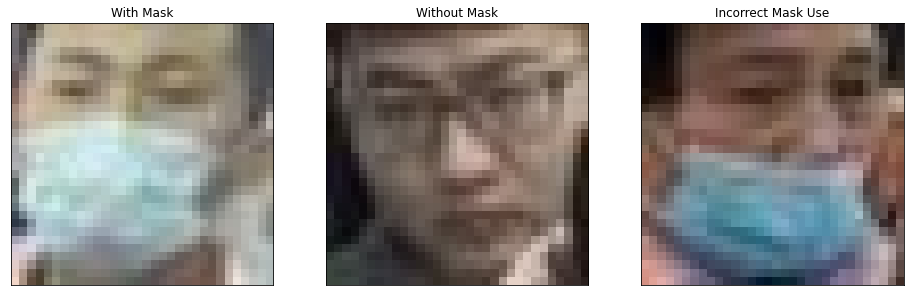

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 9))

for ax in (ax1, ax2, ax3):
    ax.set_xticks([])
    ax.set_yticks([])

ax1.imshow(imread(os.path.join(data_path, "with_mask/0003.jpg")))
ax1.set_title("With Mask")
ax2.imshow(imread(os.path.join(data_path, "without_mask/0030.jpg")))
ax2.set_title("Without Mask")
ax3.imshow(imread(os.path.join(data_path, "mask_incorrect_use/0062.jpg")))
ax3.set_title("Incorrect Mask Use")
plt.show()

We will create 3 different feature sets in order to find the optimal way to vectorize the images.

In [4]:
rgb_generator = data_utils.read_images(data_path, class_ignore=['mask_incorrect_use'])
data_rgb = data_utils.extract_features(rgb_generator, 'pixels')

gray_generator = data_utils.read_images(data_path, class_ignore=['mask_incorrect_use'], grayscale=1)
data_gray = data_utils.extract_features(gray_generator, 'pixels')

rgb_generator = data_utils.read_images(data_path, class_ignore=['mask_incorrect_use'])
data_hog = data_utils.extract_features(rgb_generator, 'hog')

In [5]:
data_rgb = data_rgb.rename(columns={data_rgb.columns[-1]: "class"})
data_gray = data_gray.rename(columns={data_gray.columns[-1]: "class"})
data_hog = data_hog.rename(columns={data_hog.columns[-1]: "class"})

In [6]:
data_rgb

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,class
0,32,19,11,52,39,31,78,65,57,96,...,41,45,56,28,34,46,30,38,51,0
1,62,42,35,74,54,47,83,60,54,82,...,39,24,19,48,39,34,54,49,45,0
2,26,8,0,50,28,14,110,81,63,154,...,7,4,0,6,5,1,5,4,0,0
3,54,54,62,67,67,75,68,66,77,56,...,53,74,67,78,95,89,102,119,111,0
4,1,4,13,0,0,7,1,1,9,3,...,55,52,61,27,24,35,5,2,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,101,80,49,105,84,53,121,96,66,143,...,161,122,107,163,120,104,146,103,87,1
2084,132,113,73,98,80,40,67,52,11,56,...,95,155,95,72,132,72,70,132,69,1
2085,86,98,60,105,112,78,120,114,88,117,...,80,72,70,89,81,79,96,88,86,1
2086,68,34,22,170,136,124,206,168,157,219,...,236,201,169,206,173,140,160,127,94,1


### Train-Validation-Test Split

In [7]:
data_rgb = data_utils.train_test_val_split(data_rgb, 0.6, 0.2)
data_gray = data_utils.train_test_val_split(data_gray, 0.6, 0.2)
data_hog = data_utils.train_test_val_split(data_hog, 0.6, 0.2)

### Feature Scaling

In [8]:
rgb_scaler = StandardScaler()
rgb_scaler.fit(data_rgb[0][data_rgb[0].columns[:-1]])
features_rgb_scaled = [pd.DataFrame(rgb_scaler.transform(dataset[dataset.columns[:-1]])) for dataset in data_rgb]

gray_scaler = StandardScaler()
gray_scaler.fit(data_gray[0][data_gray[0].columns[:-1]])
features_gray_scaled = [pd.DataFrame(gray_scaler.transform(dataset[dataset.columns[:-1]])) for dataset in data_gray]

hog_scaler = StandardScaler()
hog_scaler.fit(data_hog[0][data_hog[0].columns[:-1]])
features_hog_scaled = [pd.DataFrame(hog_scaler.transform(dataset[dataset.columns[:-1]])) for dataset in data_hog]

In [9]:
features_rgb_scaled[0]

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,1.089382,1.112500,0.840422,1.129838,1.199157,0.970093,1.097097,1.201306,1.006892,1.052672,...,0.898543,1.109601,1.030866,0.750215,0.924618,0.820148,0.509308,1.060504,0.942893,0.621632
1,-0.044647,-0.307565,-0.768745,-0.137160,-0.408723,-0.882247,-0.219826,-0.491091,-0.899074,-0.264385,...,1.052131,1.501793,1.337260,0.915057,1.300221,1.188926,0.704190,1.149673,1.021439,0.542008
2,1.924153,2.550540,2.187631,1.624276,2.156659,1.876968,0.199195,0.328936,0.053909,0.120373,...,2.314960,1.200107,1.692032,2.283244,1.270173,1.798213,2.328206,1.342872,1.854028,2.373376
3,0.790124,1.094524,1.476604,-0.276221,-0.119666,0.198285,-1.431993,-1.485593,-1.328851,-1.107894,...,1.086261,1.049264,0.837354,0.717246,0.609112,0.355165,0.200745,0.510631,0.235977,0.080184
4,0.648371,0.573235,0.054550,0.697204,0.621043,0.082513,0.663111,0.590647,0.091281,0.564325,...,0.215933,0.415722,0.369700,-0.436647,-0.187165,-0.254121,-1.130948,-0.321610,-0.376683,-1.257511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0.632620,0.285627,-0.001584,0.697204,0.386184,0.121104,0.483531,0.241699,-0.002149,0.238760,...,-0.944505,-1.122878,-1.162270,-1.096014,-1.238852,-1.360458,-1.195909,-1.361912,-1.429201,-1.305285
1248,0.679871,1.148451,1.514026,0.558143,1.090761,1.491064,0.438636,0.991938,1.399296,0.209163,...,-0.347221,-0.474252,-0.404348,-0.304773,-0.442575,-0.350325,-0.286460,-0.410779,-0.329555,-0.270164
1249,0.380614,0.788941,1.064957,0.480888,0.928166,1.259521,0.633181,1.131517,1.474040,0.727107,...,1.376371,0.581650,0.901858,1.096383,0.849498,1.172893,1.337556,0.852444,1.147113,1.306405
1250,-0.028897,0.105872,0.054550,-1.187841,-1.239763,-1.326037,-0.249756,-0.124696,-0.170323,0.653115,...,-0.347221,-0.202735,-0.226962,-0.288289,-0.036924,-0.029647,-0.124058,0.124233,0.126013,0.032410


#### Shortcuts

In [10]:
feature_sets = [features_rgb_scaled, features_gray_scaled, features_hog_scaled]
target_sets  = [[dataset[i]['class'] for i in range(len(dataset))] for dataset in [data_rgb, data_gray, data_hog]]

## Dimensionality Reduction

We will test 5 different techniques to reduce the amount of features:
- **PCA** which is an unsupervised dimensionality reduction technique, mapping the input features to a feature space with fewer dimensions.
- **Mutual Information**, which is a statistical method of measuring how independent two variables are. Thus, it can be used as a supervised feature selectiin technique, enabling the use of only the best features. Mutual Information is ideal compared to other similar methods like chi-squared because it can work with negative values too (which are present after the scaling).

In order to see which performs better, we will use two dummy classifiers (SVM and GBT).

In [11]:
svm = SVC(random_state=42)
gbt = GradientBoostingClassifier(random_state=42)

So, let's compare the validation performance for a few different reduced feature sets.

In [12]:
n_features = [5, 10, 50, 100]

In [13]:
for n in n_features:
    print("Testing", n, "features")
    for features, targets, dataset_name in zip(feature_sets, target_sets, ["rgb", "gray", "hog"]):
        print(59*"-")
        print("Testing", dataset_name, "dataset")
        for method, method_name in zip(['pca', 'mutual-info'], ["PCA", "Mutual Info"]):
            reduced_train, reduced_val = ml.reduce_dimensions(train_features=features[0],
                                                              train_target=targets[0],
                                                              test_features=features[1],
                                                              method=method,
                                                              target_dimensions=n)
        
            for model, model_name in zip([svm, gbt], ["SVM", "GBT"]):
                trained_model = ml.train(model, reduced_train, targets[0])
                accuracy = ml.test(trained_model, reduced_val, targets[1])

                print("Method:", method_name, "Classifier:", model_name, "Accuracy:", accuracy)        
        
    print(36*"--")

Testing 5 features
-----------------------------------------------------------
Testing rgb dataset
Method: PCA Classifier: SVM Accuracy: 0.9425837320574163
Method: PCA Classifier: GBT Accuracy: 0.9617224880382775
Method: Mutual Info Classifier: SVM Accuracy: 0.8444976076555024
Method: Mutual Info Classifier: GBT Accuracy: 0.8421052631578947
-----------------------------------------------------------
Testing gray dataset
Method: PCA Classifier: SVM Accuracy: 0.9114832535885168
Method: PCA Classifier: GBT Accuracy: 0.9114832535885168
Method: Mutual Info Classifier: SVM Accuracy: 0.7655502392344498
Method: Mutual Info Classifier: GBT Accuracy: 0.7607655502392344
-----------------------------------------------------------
Testing hog dataset
Method: PCA Classifier: SVM Accuracy: 0.9425837320574163
Method: PCA Classifier: GBT Accuracy: 0.9354066985645934
Method: Mutual Info Classifier: SVM Accuracy: 0.8588516746411483
Method: Mutual Info Classifier: GBT Accuracy: 0.8492822966507177
--------

It is obvious that PCA consistently outperformed Mutual Information, including in terms of speed. As a result, this is the algorithm that will be used from now on.

As for the datasets, gray is considerably worse, while the rest are quite similar in performance.

## Classifier Selection

Now we need to find the classifiers that best works with our data. Once again, many different classifiers will be tried and compared with a few different PCA configurations.

Given that our data are not easy to visualize, it is not possible to use any heuristics before trying them.

Since the data were already scaled before PCA, there is no need to scale them for linear models.

In [14]:
classifier_names = [
    "Neural Net",
    "Nearest Neighbors",
    "RBF SVM",
    "Linear SVM",
    "Decision Tree",
    "Random Forest",
    "Gradient Boosting",
    "AdaBoost",
    "Naive Bayes",
    "XGBoost",
    "Logistic Regression"
]

classifiers = [
    MLPClassifier(max_iter=1000, random_state=42),
    KNeighborsClassifier(3),
    SVC(kernel='rbf', random_state=42),
    SVC(kernel='linear', random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    XGBClassifier(random_state=42),
    LogisticRegression(random_state=42)
]

In [15]:
for n in [5, 50, 100]:
    print("Testing", n, "features")
    for features, targets, dataset_name in zip(feature_sets, target_sets, ["rgb", "gray", "hog"]):
        print(59*"-")
        print("Testing", dataset_name, "dataset")
        reduced_train, reduced_val = ml.reduce_dimensions(train_features=features[0],
                                                          train_target=targets[0],
                                                          test_features=features[1],
                                                          method='pca',
                                                          target_dimensions=n)
        
        for classifier, classifier_name in zip(classifiers, classifier_names):
            trained_model = ml.train(classifier, reduced_train, targets[0])
            accuracy = ml.test(trained_model, reduced_val, targets[1])

            print("Classifier:", classifier_name, "Accuracy:", accuracy)
            
    print(36*"--")

Testing 5 features
-----------------------------------------------------------
Testing rgb dataset
Classifier: Neural Net Accuracy: 0.9569377990430622
Classifier: Nearest Neighbors Accuracy: 0.9354066985645934
Classifier: RBF SVM Accuracy: 0.9425837320574163
Classifier: Linear SVM Accuracy: 0.9401913875598086
Classifier: Decision Tree Accuracy: 0.9234449760765551
Classifier: Random Forest Accuracy: 0.9617224880382775
Classifier: Gradient Boosting Accuracy: 0.9617224880382775
Classifier: AdaBoost Accuracy: 0.9497607655502392
Classifier: Naive Bayes Accuracy: 0.930622009569378
Classifier: XGBoost Accuracy: 0.9617224880382775
Classifier: Logistic Regression Accuracy: 0.937799043062201
-----------------------------------------------------------
Testing gray dataset
Classifier: Neural Net Accuracy: 0.9066985645933014
Classifier: Nearest Neighbors Accuracy: 0.9090909090909091
Classifier: RBF SVM Accuracy: 0.9114832535885168
Classifier: Linear SVM Accuracy: 0.861244019138756
Classifier: Decis

The best classifiers were RF and GB (XGBoost outperformed sklearn's Gradient Boosting) for fewer features and the NN and SVM for more features.

## Parameter Tuning

Having narrowed down significantly the search space, we can now find the best parameters, including the selected classifier hyperparameters.

The grayscale dataset will not be used, since it had the worse performance thus far.

In [16]:
del target_sets[1]
del feature_sets[1]

The process will be performed in two steps, one for finding the order of magnitude, and another for fine-tuning.

In [17]:
classifier_names = [
    "Neural Net",
    "RBF SVM",
    "Random Forest",
    "XGBoost"
]

classifiers = [
    MLPClassifier(max_iter=1000, random_state=42),
    SVC(kernel='rbf', random_state=42),
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42, n_jobs=-1)
]

classifier_params = [
    [{'hidden_layer_sizes':layers, 'alpha':reg, 'learning_rate_init': lr}
     for layers in [(32,), (64,), (32, 64)]
     for reg in [0.0001, 0.001, 0.1]
     for lr in [0.001, 0.01]
    ],
    [{'C':c, 'gamma':g}
     for c in [0.001, 0.1, 1.0, 10, 1000]
     for g in ['scale', 0.000001, 0.0001, 0.1, 1]
    ],
    [{'n_estimators':n, 'max_depth':depth, 'min_samples_split':split, 'min_samples_leaf':sample}
     for n in [50, 100, 500]
     for depth in [None, 10, 50]
     for split in [2, 8, 32]
     for sample in [1, 2]
    ],
    [{'n_estimators':n, 'max_depth':depth, 'learning_rate':lr, 'colsample_bytree':col, 'subsample':sample, 'gamma':g}
     for n in [50, 100, 500]
     for depth in [3, 5, 10]
     for lr in [0.01]
     for col in [0.1, 0.5, 1]
     for sample in [0.1, 0.5]
     for g in [0, 5]
    ]
]

In [18]:
accuracies = []
for n in [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    for features, targets, dataset_name in zip(feature_sets, target_sets, ["rgb", "hog"]):
        reduced_train, reduced_val = ml.reduce_dimensions(train_features=features[0],
                                                          train_target=targets[0],
                                                          test_features=features[1],
                                                          method='pca',
                                                          target_dimensions=n)
        
        for classifier, classifier_name, params in zip(classifiers, classifier_names, classifier_params):
            for param_set in params:
                classifier.set_params(**param_set)
                trained_model = ml.train(classifier, reduced_train, targets[0])
                accuracy = ml.test(trained_model, reduced_val, targets[1])

                accuracies.append((accuracy, dataset_name, n, classifier_name, param_set))

In [19]:
accuracies_df = pd.DataFrame(sorted(accuracies, key=lambda tup: tup[0], reverse=True), columns=['accuracy', 'data', 'num_features', 'classifier', 'params'])
print("Number of combinations tested:", accuracies_df.shape[0])

Number of combinations tested: 4920


In [21]:
accuracies_df.head(15)

,accuracy,data,num_features,classifier,params
0,0.973684,rgb,10,RBF SVM,"{'C': 10, 'gamma': 0.0001}"
1,0.971292,hog,30,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.1, 'learning_rate_init': 0.01}"
2,0.971292,hog,50,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.1, 'learning_rate_init': 0.01}"
3,0.971292,hog,80,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.1, 'learning_rate_init': 0.01}"
4,0.971292,hog,100,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.1, 'learning_rate_init': 0.01}"
5,0.968900,hog,30,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.0001, 'learning_rate_init': 0.01}"
6,0.968900,hog,30,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.001, 'learning_rate_init': 0.01}"
7,0.968900,hog,30,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.1, 'learning_rate_init': 0.001}"
8,0.968900,hog,40,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.0001, 'learning_rate_init': 0.01}"
9,0.968900,hog,40,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.001, 'learning_rate_init': 0.01}"


In [22]:
accuracies_df[accuracies_df['data']=='rgb'].head(25)

,accuracy,data,num_features,classifier,params
0,0.973684,rgb,10,RBF SVM,"{'C': 10, 'gamma': 0.0001}"
12,0.966507,rgb,5,Random Forest,"{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}"
13,0.966507,rgb,5,Random Forest,"{'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 2}"
14,0.966507,rgb,5,XGBoost,"{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 1, 'subsample': 0.5, 'gamma': 0}"
15,0.966507,rgb,5,XGBoost,"{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 1, 'subsample': 0.5, 'gamma': 0}"
16,0.966507,rgb,10,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.0001, 'learning_rate_init': 0.001}"
17,0.966507,rgb,10,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.001, 'learning_rate_init': 0.001}"
18,0.966507,rgb,10,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.1, 'learning_rate_init': 0.001}"
19,0.966507,rgb,10,Neural Net,"{'hidden_layer_sizes': (32, 64), 'alpha': 0.0001, 'learning_rate_init': 0.001}"
20,0.966507,rgb,10,Neural Net,"{'hidden_layer_sizes': (32, 64), 'alpha': 0.001, 'learning_rate_init': 0.001}"


In [23]:
accuracies_df[accuracies_df['data']=='hog'].head(25)

,accuracy,data,num_features,classifier,params
1,0.971292,hog,30,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.1, 'learning_rate_init': 0.01}"
2,0.971292,hog,50,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.1, 'learning_rate_init': 0.01}"
3,0.971292,hog,80,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.1, 'learning_rate_init': 0.01}"
4,0.971292,hog,100,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.1, 'learning_rate_init': 0.01}"
5,0.968900,hog,30,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.0001, 'learning_rate_init': 0.01}"
6,0.968900,hog,30,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.001, 'learning_rate_init': 0.01}"
7,0.968900,hog,30,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.1, 'learning_rate_init': 0.001}"
8,0.968900,hog,40,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.0001, 'learning_rate_init': 0.01}"
9,0.968900,hog,40,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.001, 'learning_rate_init': 0.01}"
10,0.968900,hog,40,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.1, 'learning_rate_init': 0.001}"


In [26]:
accuracies_df[accuracies_df['classifier']=='Random Forest'].head(15)

,accuracy,data,num_features,classifier,params
12,0.966507,rgb,5,Random Forest,"{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}"
13,0.966507,rgb,5,Random Forest,"{'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 2}"
21,0.966507,rgb,10,Random Forest,"{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}"
31,0.966507,rgb,50,Random Forest,"{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}"
32,0.966507,rgb,50,Random Forest,"{'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 2}"
54,0.964115,rgb,5,Random Forest,"{'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1}"
55,0.964115,rgb,5,Random Forest,"{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}"
59,0.964115,rgb,10,Random Forest,"{'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}"
60,0.964115,rgb,10,Random Forest,"{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}"
61,0.964115,rgb,10,Random Forest,"{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 1}"


In [27]:
accuracies_df[accuracies_df['classifier']=='RBF SVM'].head(15)

,accuracy,data,num_features,classifier,params
0,0.973684,rgb,10,RBF SVM,"{'C': 10, 'gamma': 0.0001}"
22,0.966507,hog,30,RBF SVM,"{'C': 1.0, 'gamma': 'scale'}"
23,0.966507,hog,30,RBF SVM,"{'C': 1000, 'gamma': 0.0001}"
28,0.966507,hog,40,RBF SVM,"{'C': 1.0, 'gamma': 'scale'}"
29,0.966507,hog,40,RBF SVM,"{'C': 10, 'gamma': 'scale'}"
30,0.966507,hog,40,RBF SVM,"{'C': 1000, 'gamma': 'scale'}"
37,0.966507,rgb,60,RBF SVM,"{'C': 1000, 'gamma': 1e-06}"
40,0.966507,hog,70,RBF SVM,"{'C': 10, 'gamma': 'scale'}"
41,0.966507,hog,70,RBF SVM,"{'C': 1000, 'gamma': 'scale'}"
43,0.966507,hog,80,RBF SVM,"{'C': 10, 'gamma': 'scale'}"


In [28]:
accuracies_df[accuracies_df['classifier']=='XGBoost'].head(15)

,accuracy,data,num_features,classifier,params
14,0.966507,rgb,5,XGBoost,"{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 1, 'subsample': 0.5, 'gamma': 0}"
15,0.966507,rgb,5,XGBoost,"{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 1, 'subsample': 0.5, 'gamma': 0}"
56,0.964115,rgb,5,XGBoost,"{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1, 'subsample': 0.5, 'gamma': 0}"
64,0.964115,rgb,10,XGBoost,"{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1, 'subsample': 0.5, 'gamma': 0}"
65,0.964115,rgb,10,XGBoost,"{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 1, 'subsample': 0.5, 'gamma': 0}"
108,0.961722,rgb,5,XGBoost,"{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1, 'subsample': 0.5, 'gamma': 5}"
109,0.961722,rgb,5,XGBoost,"{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 1, 'subsample': 0.5, 'gamma': 5}"
119,0.961722,rgb,10,XGBoost,"{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 1, 'subsample': 0.5, 'gamma': 0}"
120,0.961722,rgb,10,XGBoost,"{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1, 'subsample': 0.5, 'gamma': 0}"
134,0.961722,rgb,30,XGBoost,"{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1, 'subsample': 0.1, 'gamma': 0}"


In [25]:
accuracies_df[accuracies_df['num_features'] < 50].head(25)

,accuracy,data,num_features,classifier,params
0,0.973684,rgb,10,RBF SVM,"{'C': 10, 'gamma': 0.0001}"
1,0.971292,hog,30,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.1, 'learning_rate_init': 0.01}"
5,0.968900,hog,30,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.0001, 'learning_rate_init': 0.01}"
6,0.968900,hog,30,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.001, 'learning_rate_init': 0.01}"
7,0.968900,hog,30,Neural Net,"{'hidden_layer_sizes': (32,), 'alpha': 0.1, 'learning_rate_init': 0.001}"
8,0.968900,hog,40,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.0001, 'learning_rate_init': 0.01}"
9,0.968900,hog,40,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.001, 'learning_rate_init': 0.01}"
10,0.968900,hog,40,Neural Net,"{'hidden_layer_sizes': (64,), 'alpha': 0.1, 'learning_rate_init': 0.001}"
11,0.968900,hog,40,Neural Net,"{'hidden_layer_sizes': (32, 64), 'alpha': 0.1, 'learning_rate_init': 0.01}"
12,0.966507,rgb,5,Random Forest,"{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}"


In [107]:
accuracies_df['num_features'].head(50).mean()

45.4

In [108]:
accuracies_df['num_features'].head(50).median()

40.0

All algorithms performed well for some combination of parameters.
- The best results were for less than 50 features (the mean and median of the top-25 is 30).
- hog dataset performed better for SVM and NN and rgb was better for XGB and RF.
- The tree-based methods and SVM need less features than the Neural Network.
- The Neural network was by far the slowest classifier, followed by SVM.
- XGBoost is more robust against overfitting compared to both SVM (since we used a large C value) and the Neural Network

The best parameter set for each algorithm seem to be:
- NN: hidden_layers=(32,) (other parameters did not affect that much).
- SVM: gamma=0.0001 or 'scale' (which is evaluated in the region of 0.01-1) and C>1
- XGB: max_depth=10, colsample_bytree=1, subsample=0.5, gamma=0 and n_estimators > 100 (probably even 500)
- RF: n_estimators=100 (possibly more), max_depth=None (or something big), min_samples_split=2, min_samples_leaf=2

### Fine Tuning

Now that a baseline is established and the search space is reduced, we can try to fine-tune the parameters of the algorithms (including some more tweaking of the MLP).

In [149]:
classifier_names = [
    "mlp",
    "svm",
    "rf",
    "xgb"
]

classifiers = [
    MLPClassifier(max_iter=1000, random_state=42),
    SVC(kernel='rbf', random_state=42),
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42, n_jobs=-1)
]

classifier_params = [
    [{'hidden_layer_sizes': layers, 'activation': activation, 'alpha': reg, 'learning_rate_init': lr}
     for layers in [(32,), (32,32)]
     for activation in ['relu', 'tanh']
     for reg in [0.5, 0.3, 0.1, 0.05, 0.03]
     for lr in [0.01]
    ],
    [{'C': c, 'gamma': g}
     for c in [1.0, 10, 100, 200, 500, 1000]
     for g in ['scale', 0.0001, 0.0005, 0.001, 0.01, 0.05]
    ],
    [{'n_estimators':n, 'max_depth': depth, 'min_samples_leaf': sample}
     for n in [100, 200, 400]
     for depth in [None, 100]
     for sample in [2]
    ],
    [{'n_estimators': n, 'max_depth': depth, 'learning_rate': lr, 'subsample': sample, 'gamma': g}
     for n in [100, 500, 1000]
     for depth in [5, 8, 10]
     for lr in [0.01]
     for sample in [0.5]
     for g in [0]
    ]
]

In [150]:
fine_accuracies = []
for n in [25, 27, 29, 30, 31, 33, 35, 37]:
    reduced_train, reduced_val = ml.reduce_dimensions(train_features=feature_sets[-1][0],
                                                      train_target=target_sets[-1][0],
                                                      test_features=feature_sets[-1][1],
                                                      method='pca',
                                                      target_dimensions=n)

    for classifier, classifier_name, params in zip(classifiers, classifier_names, classifier_params):
        for param_set in params:
            classifier.set_params(**param_set)
            trained_model = ml.train(classifier, reduced_train, targets[0])
            accuracy = ml.test(trained_model, reduced_val, targets[1])

            fine_accuracies.append((accuracy, n, classifier_name, param_set))

In [151]:
fine_accuracies_df = pd.DataFrame(sorted(fine_accuracies, key=lambda tup: tup[0], reverse=True), columns=['accuracy', 'num_features', 'classifier', 'params'])
print("Number of combinations tested:", fine_accuracies_df.shape[0])

Number of combinations tested: 568


In [154]:
fine_accuracies_df.head(25)

,accuracy,num_features,classifier,params
0,0.976077,33,RBF SVM,"{'C': 1000, 'gamma': 0.0001}"
1,0.971292,25,Neural Net,"{'hidden_layer_sizes': (32,), 'activation': 'tanh', 'alpha': 0.05, 'learning_rate_init': 0.01}"
2,0.971292,27,RBF SVM,"{'C': 10, 'gamma': 0.01}"
3,0.971292,27,RBF SVM,"{'C': 100, 'gamma': 0.01}"
4,0.971292,27,RBF SVM,"{'C': 200, 'gamma': 0.01}"
5,0.971292,27,RBF SVM,"{'C': 500, 'gamma': 0.01}"
6,0.971292,27,RBF SVM,"{'C': 1000, 'gamma': 0.01}"
7,0.971292,29,RBF SVM,"{'C': 100, 'gamma': 0.0005}"
8,0.971292,30,Neural Net,"{'hidden_layer_sizes': (32,), 'activation': 'relu', 'alpha': 0.1, 'learning_rate_init': 0.01}"
9,0.971292,30,Neural Net,"{'hidden_layer_sizes': (32,), 'activation': 'relu', 'alpha': 0.05, 'learning_rate_init': 0.01}"


In [159]:
fine_accuracies_df[fine_accuracies_df['classifier']=='XGBoost'][fine_accuracies_df['num_features']==33].head()

/tmp/ipykernel_25545/3508977982.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fine_accuracies_df[fine_accuracies_df['classifier']=='XGBoost'][fine_accuracies_df['num_features']==33].head()


,accuracy,num_features,classifier,params
345,0.956938,33,XGBoost,"{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01, 'subsample': 0.5, 'gamma': 0}"
346,0.956938,33,XGBoost,"{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'subsample': 0.5, 'gamma': 0}"
347,0.956938,33,XGBoost,"{'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01, 'subsample': 0.5, 'gamma': 0}"
348,0.956938,33,XGBoost,"{'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.01, 'subsample': 0.5, 'gamma': 0}"
398,0.954545,33,XGBoost,"{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'gamma': 0}"


In [160]:
fine_accuracies_df[fine_accuracies_df['classifier']=='Random Forest'][fine_accuracies_df['num_features']==33].head()

/tmp/ipykernel_25545/3154017209.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fine_accuracies_df[fine_accuracies_df['classifier']=='Random Forest'][fine_accuracies_df['num_features']==33].head()


,accuracy,num_features,classifier,params
461,0.949761,33,Random Forest,"{'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 2}"
462,0.949761,33,Random Forest,"{'n_estimators': 200, 'max_depth': 100, 'min_samples_leaf': 2}"
463,0.949761,33,Random Forest,"{'n_estimators': 400, 'max_depth': None, 'min_samples_leaf': 2}"
464,0.949761,33,Random Forest,"{'n_estimators': 400, 'max_depth': 100, 'min_samples_leaf': 2}"
495,0.947368,33,Random Forest,"{'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 2}"


In [164]:
fine_accuracies_df[fine_accuracies_df['classifier']=='Neural Net'][fine_accuracies_df['num_features']==33].head()

/tmp/ipykernel_25545/392348450.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fine_accuracies_df[fine_accuracies_df['classifier']=='Neural Net'][fine_accuracies_df['num_features']==33].head()


,accuracy,num_features,classifier,params
11,0.971292,33,Neural Net,"{'hidden_layer_sizes': (32,), 'activation': 'tanh', 'alpha': 0.3, 'learning_rate_init': 0.01}"
12,0.971292,33,Neural Net,"{'hidden_layer_sizes': (32, 32), 'activation': 'tanh', 'alpha': 0.03, 'learning_rate_init': 0.01}"
106,0.966507,33,Neural Net,"{'hidden_layer_sizes': (32,), 'activation': 'tanh', 'alpha': 0.5, 'learning_rate_init': 0.01}"
107,0.966507,33,Neural Net,"{'hidden_layer_sizes': (32, 32), 'activation': 'tanh', 'alpha': 0.05, 'learning_rate_init': 0.01}"
232,0.961722,33,Neural Net,"{'hidden_layer_sizes': (32,), 'activation': 'relu', 'alpha': 0.5, 'learning_rate_init': 0.01}"


### Results Analysis

Now, we will try to consolidate the best individual algorithms and see if there is any overlap between the samples that were predicted wrong.

In [161]:
X_train = feature_sets[-1][0]
y_train = target_sets[-1][0]
X_val = feature_sets[-1][1]
y_val = target_sets[-1][1]

In [162]:
X_train, X_val = ml.reduce_dimensions(X_train, y_train, X_val, method='pca', target_dimensions=33)

In [177]:
svm = SVC(kernel='rbf', C=1000, gamma=0.0001, random_state=42)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_val)
print("Accuracy:", ml.test(svm, X_val, y_val))

Accuracy: 0.9760765550239234


In [178]:
mlp = MLPClassifier(hidden_layer_sizes=(32,), activation='tanh', alpha=0.3, learning_rate_init=0.01, max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_val)
print("Accuracy:", ml.test(mlp, X_val, y_val))

Accuracy: 0.9712918660287081


In [179]:
xgb = XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.01, subsample=0.5, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)
print("Accuracy:", ml.test(xgb, X_val, y_val))

Accuracy: 0.9569377990430622


In [180]:
rf  = RandomForestClassifier(n_estimators=200, min_samples_leaf=2, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
print("Accuracy:", ml.test(rf, X_val, y_val))

Accuracy: 0.9497607655502392


In [181]:
print("MLP misclassifications:", (mlp_pred != y_val).sum())
print("SVM misclassifications:",(svm_pred != y_val).sum())
print("XGB misclassifications:",(xgb_pred != y_val).sum())
print("RF misclassifications:",(rf_pred != y_val).sum())

MLP misclassifications: 12
SVM misclassifications: 10
XGB misclassifications: 18
RF misclassifications: 21


In [237]:
print("Misclassified by all:", ((svm_pred != y_val) & (mlp_pred != y_val) & (xgb_pred != y_val) & (rf_pred != y_val)).sum())

Misclassified by all: 5


In [236]:
print("Misclassified by all:", ((svm_pred != y_val) & (mlp_pred != y_val)).sum())

Misclassified by all: 8


Since only 5 samples were not classified by any algorithm (and only 3 unique between RF and XGB) and each algorithm works with different principles and assumptions, it could be a good idea to stack them.

### Stacking

In [66]:
from sklearn.ensemble import StackingClassifier

Only the two best models will be used for the initial classifiers, but we will try everything as the meta-classifier, including appending the train data or not.

In [231]:
level_0 = [
    ('mlp', mlp),
    ('svm', svm),
]

level_1 = [
    ('mlp', mlp),
    ('svm', svm),
    ('xgb', xgb),
    ('rf ' , rf)
]

In [232]:
for clf in level_1:
    for use_data in [True, False]:
        stacking = StackingClassifier(estimators=classifiers, final_estimator=clf[1], passthrough=use_data)
        stacking.fit(X_train, y_train)
        accuracy = ml.test(stacking, X_val, y_val)
        
        print("Accuracy:", accuracy, "Meta-Classifier:", clf[0], "Use Data:", use_data)

Accuracy: 0.9497607655502392 Meta-Classifier: mlp Use Data: True
Accuracy: 0.9736842105263158 Meta-Classifier: mlp Use Data: False
Accuracy: 0.9688995215311005 Meta-Classifier: svm Use Data: True
Accuracy: 0.9712918660287081 Meta-Classifier: svm Use Data: False
Accuracy: 0.9784688995215312 Meta-Classifier: xgb Use Data: True
Accuracy: 0.9712918660287081 Meta-Classifier: xgb Use Data: False
Accuracy: 0.9760765550239234 Meta-Classifier: rf Use Data: True
Accuracy: 0.9688995215311005 Meta-Classifier: rf Use Data: False


And after taking the best of those models.

In [240]:
stacking = StackingClassifier(estimators=classifiers, final_estimator=xgb, passthrough=True)
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('mlp',
                                MLPClassifier(activation='tanh', alpha=0.3,
                                              hidden_layer_sizes=(32,),
                                              learning_rate_init=0.01,
                                              max_iter=1000, random_state=42)),
                               ('svm',
                                SVC(C=1000, gamma=0.0001, random_state=42))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=Non...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.01,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=8, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=500, n_jobs=-1,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=42, ...),
                   passthrough=True)

In [244]:
stack_pred = stacking.predict(X_val)
print("Stacking misclassifications:", (stack_pred != y_val).sum())

Stacking misclassifications: 9


Indeed, this performs better than each of the two individual models.